# Deep Learning: common issues and solutions


Main part of the lab

1) **Text preprocessing with Tensorflow API**

2) **The vanishing gradient problem**:

Problem: Your model does not learn at all ! Possible solutions, obviously with their pros and cons:
- Reduce the depth of your network.
- Use sparsity promoting activation functions such as the ReLU activation function, i.e ReLU(x)= max(0, x)
- Use residual connections, i.e output at each layer: layer(input) + input
- Use normalization techniques, e.g Batch Normalization and so on.
    
3) **Underfitting and Overfitting problems**
Problems:

    - Underfitting relates to the fact that your model does not learn enough on the train dataset to hope for good generalization abilities (good label prediction on new samples with unknown labels).
    - Overfitting means that your model fits too much to the train dataset, which can also prevents it from generalizing well to new samples with unknown labels.
    
Possible solutions to underfitting:
- Increase the network capacity, like creating a deeper and/or wider architecture.
Possible solutions to overfitting:
- Naturally, reduce the network capacity by decreasing its number of parameters.
- Explicit regularization: Constrain the parameters of your network, for instance by adding their euclidean norm to the objective loss function to minimize. (L2 Regularization)
- Implicit regularization: Use Dropout Layers which deactivate parts of your network, uniformly at random, at each iteration.

The following part are mandatory for MSc. DSAI students and optional for others.

4) **Starting, stopping, and resuming training**

Learning how to start, stop and resume learning a deep learning model is a very important skill to master. At some point:

* You have limited time on a GPU instance (this can happen on Google Colab or when using the cheaper Amazon EC2 point instances).
* Your SSH connection is broken.
* Your deep learning platform crashes and shuts down.

Imagine you've spent a whole week training a state-of-the-art deep neural network... and your model is lost due to a power failure!

5) Find best hyper-parameters with keras-tuner

## Some imports

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
!pip install keras-tuner --upgrade
import keras_tuner

In [ ]:
### Some global constant
epochs=100
batch_size=256
patience=10
hidden_dim=256

In [ ]:
### Usual function for babysit the network

# It is important to systematically observe the learning curves
def babysit(history):
    keys = [key for key in history.keys() if key[:4] != "val_"]
    fig, ax = plt.subplots(nrows=1, ncols=len(keys), figsize=(18, 5))
    for i, key in enumerate(keys):
        ax[i].plot(history[key], label=key)
        if "val_"+key in history.keys():
            ax[i].plot(history["val_"+key], label="val_"+key)
        ax[i].legend()
        ax[i].set_title(key)
    plt.show()

In [ ]:
### Usual callback for training deep learning model

# It is important to use early stopping systematically
callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max',
                                patience=patience,
                                restore_best_weights=True)]

## Dataset

In this lab we use part of the 'Amazon_Unlocked_Mobile.csv' dataset published by Kaggle. The dataset contain the following information:
* Product Name
* Brand Name
* Price
* Rating
* Reviews
* Review Votes

We are mainly interested by the 'Reviews' (X) and by the 'Rating' (y)

The goal is to try to predict the 'Rating' after reading the 'Reviews'.

Train, validation and test sets](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)
![test/train/val](https://miro.medium.com/max/1466/1*aNPC1ifHN2WydKHyEZYENg.png)

* **Training Dataset:** The sample of data used to fit the model.
* **Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
* **Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

**If you use cross validation, concatenate Train and Validation set.**

In [ ]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.00,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


In [ ]:
# Construct X_train and y_train
X_train = np.array(TRAIN['Reviews'].fillna("")).reshape((-1,1))
y_train = np.array(TRAIN['Rating']).reshape((-1,1))
X_train.shape, y_train.shape
#predict the value of rating
#the training set = 5000 lignes

((5000, 1), (5000, 1))

In [ ]:
# Construct X_test and y_test
X_test = np.array(TEST['Reviews'].fillna("")).reshape((-1,1))
y_test = np.array(TEST['Rating']).reshape((-1,1))
X_test.shape, y_test.shape
#the trainning set 1000 lignes

((1000, 1), (1000, 1))

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train_encoded = ohe.fit_transform(y_train)
y_test_encoded = ohe.transform(y_test)
print(y_test_encoded)

#encoding the rating values 1,2,3,4,5 we use one hot encoding for classification problems

In [ ]:
# Define constant
n_classes = len(np.unique(y_train))
# This part of the code calculates the unique values in the y_train variable, assuming that y_train is a NumPy array or a similar data structure. In the context of classification tasks, this is typically the array of labels or target values.
feature_vector_length = X_train.shape[1]
feature_vector_length, n_classes

(1, 5)

## Text preprocessing with tensorflow

To work with text, you need to transform it into a form that can be manipulated. In this lab, we've chosen to use the notion of document-term matrix.

A document-term matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms.

Tensorflow has a function to perform this transformation: [tf.keras.layers.TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization)

Look at the Tensorflow documentation to understand how it works.

The main parameter is output_mode:
* "int": Outputs integer indices, one integer index per split string token. When output_mode == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens - 2 instead of max_tokens - 1.
    * give an ID for each token
* 'multi_hot', 'count', 'tf_idf': gives similar vectoror as CountVectorizer or TfIdfVectorizer. But what are the differences?
    * give a document-term matrix representation of the sentence
    
Below is a small example of use:

In [ ]:
corpus = ["I love chocolate and I hate beer",
          "I love beer and I hate chocolate",
          "I love beer and I love chocolate"]
corpus = tf.convert_to_tensor(corpus)

for output_mode in ['multi_hot', 'count', 'tf_idf', 'int']:
    print("-"*50)
    print("output_mode:", output_mode)
    vectorize_layer = layers.TextVectorization(output_mode=output_mode)
    vectorize_layer.adapt(corpus) # Do the same thinks as fit in sklearn library
    print(vectorize_layer.get_vocabulary())
    print(vectorize_layer(corpus))

<font color="red">[TO DO STUDENTS]</font>

It is up to you to build examples with the other parameters of the TextVectorization function

In [ ]:
""" Your code here """

' Your code here '

<font color="red">[ TO DO STUDENTS]</font>

Create and initialize your vectorizer layer according to the training data in order to obtain a document-term matrix representation.

In [ ]:
print("count")
vectorize_layer = layers.TextVectorization(output_mode='count')
vectorize_layer.adapt(X_train) # Do the same thinks as fit in sklearn library
print("Vocabulary")
print(vectorize_layer.get_vocabulary())
print(vectorize_layer(corpus))

## Step 1. Vanishing gradient problem

This problem can be encountered when training NN with gradient-based learning methods and backpropagation. In such methods, during each iteration of training each of the neural network's weights receives an update proportional to the partial derivative of the loss function with respect to the current weight. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. This mostly occurs when your architecture counts too many parameters to learn.

Possible solutions, obviously with their pros and cons:

* Reduce the depth of your network.
* Use sparsity promoting activation functions such as the ReLU activation function, i.e ReLU(x)= max(0, x)
* Use residual connections, i.e output at each layer: layer(input) + input
* Use normalization techniques, e.g Batch Normalization and so on.

### a) Observe the vanishing gradient problem

<font color="red">[ TO DO STUDENTS]</font>

Design a function to simply build MLP with the following inputs, which return the model ready to compile:

* vectorizer: the vectorizer layer used to transform a sentence in a vector</font>
* activation: activation used at each hidden layer
* n_hiddenlayers: number of hidden layers in the network
* hidden_dim: shared number of neurons within each hidden layer

In [ ]:
def build_model(vectorizer, activation, n_hiddenlayers, hidden_dim):
    inputs = tf.keras.Input(shape=(feature_vector_length,), dtype='string')
    x = vectorize_layer(inputs)
    for _ in range(n_hiddenlayers):
        x = tf.keras.layers.Dense(hidden_dim, activation=activation)(x)

    outputs = tf.keras.layers.Dense(n_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

    #A "vectorizer" : transforms textual data into numerical vectors.

In [ ]:
# Build a network with 30 hidden layers with 'tanh' activations
model = build_model(vectorize_layer, 'tanh', 30, hidden_dim)

In [ ]:
# Print the model
model.summary()
#the input is 11001 for the first layer 11001*256+256

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 11001)             0         
 Vectorization)                                                  
                                                                 
 dense (Dense)               (None, 256)               2816512   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                             

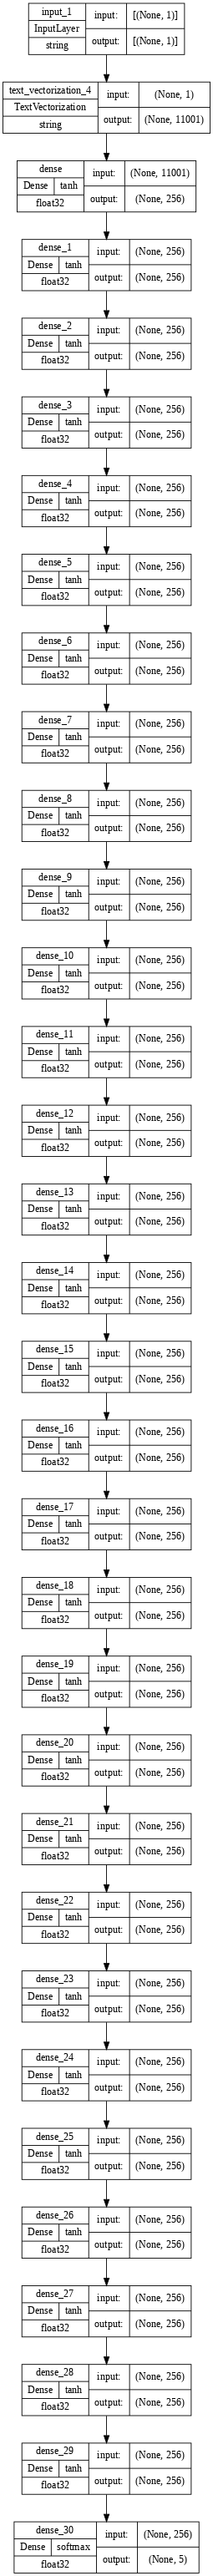

In [ ]:
# Plot the model
plot_model(model, show_shapes=True,
    show_dtype=True,
    #show_layer_names=True,
    #rankdir="TB",
    #expand_nested=True,
    dpi=64,
    #layer_range=True,
    show_layer_activations=True,
)

<font color="red">You now know 2 ways to view your network. You can choose the one you prefer.</font>

In [ ]:
# Configure the model and start training, use the defined early stopping
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])
history = model.fit(X_train, y_train_encoded,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 10s 196ms/step - loss: 1.5270 - accuracy: 0.4415 - val_loss: 1.3345 - val_accuracy: 0.5530
Epoch 2/100
16/16 [==============================] - 3s 160ms/step - loss: 1.3163 - accuracy: 0.5345 - val_loss: 1.3080 - val_accuracy: 0.5530
Epoch 3/100
16/16 [==============================] - 3s 160ms/step - loss: 1.3039 - accuracy: 0.5343 - val_loss: 1.2922 - val_accuracy: 0.5530
Epoch 4/100
16/16 [==============================] - 4s 277ms/step - loss: 1.3234 - accuracy: 0.5345 - val_loss: 1.2966 - val_accuracy: 0.5530
Epoch 5/100
16/16 [==============================] - 3s 170ms/step - loss: 1.3096 - accuracy: 0.5345 - val_loss: 1.2985 - val_accuracy: 0.5530
Epoch 6/100
16/16 [==============================] - 3s 163ms/step - loss: 1.3008 - accuracy: 0.5345 - val_loss: 1.2943 - val_accuracy: 0.5530
Epoch 7/100
16/16 [==============================] - 3s 162ms/step - loss: 1.3000 - accuracy: 0.5343 - val_loss: 1.2892 - val_accuracy: 0.553

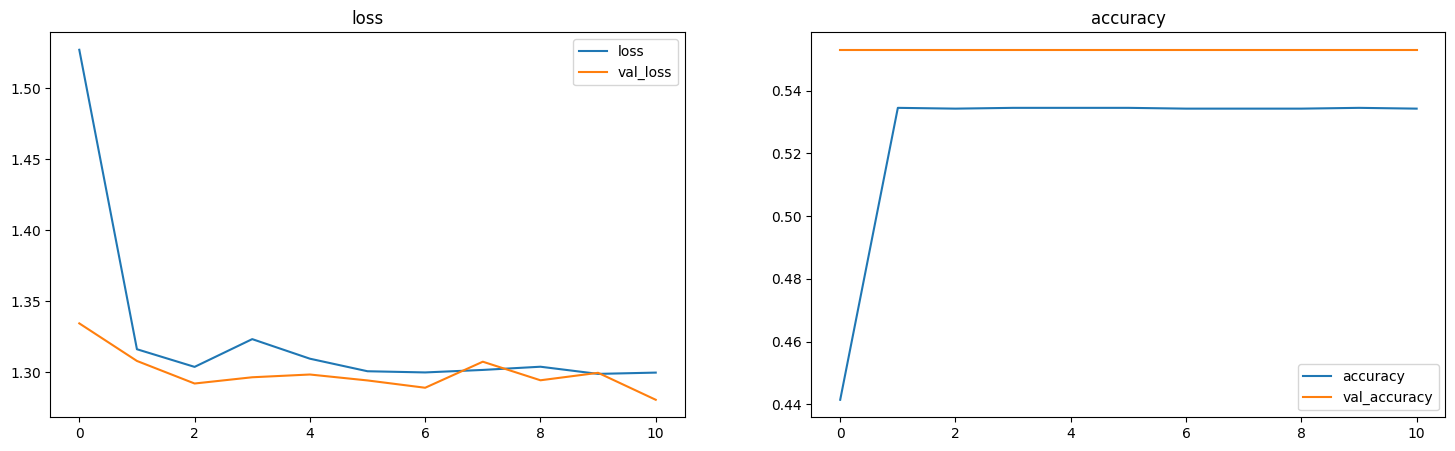

In [ ]:
# Plot the learning curves and analyze them
babysit(history.history)

<font color="red">[ TO DO STUDENTS]</font>

Is your network learning? Check your intuition by evaluating your model and looking at the confusion matrix.

The model isn't learning because it gets wrong values for half of the dataset

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.5559999942779541


32/32 [==============================] - 2s 29ms/step


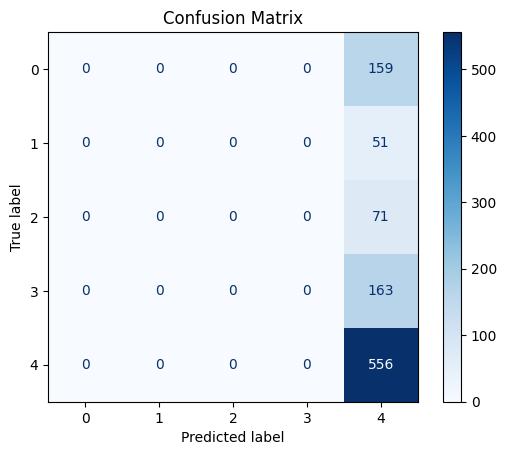

In [ ]:
# Print/plot the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(n_classes))
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### b) Experiment on ReLU activation

<font color="red">[ TO DO STUDENTS]</font>

Change activation from 'tanh' to 'relu', still with a deep network.

In [ ]:
#Non-saturation: The sigmoid activation function, which squashes input values to the range [0, 1],
#tends to saturate when the input is too large or too small. This saturation leads to small gradients,
#contributing to the vanishing gradient problem. ReLU,
#on the other hand, does not saturate for positive input values, allowing gradients to flow more freely during backpropagation.
#ReLU activation leads to sparse activation patterns because it only activates for positive inputs. Sparse activations help in creating a more efficient and expressive representation of the input data.

# Build a network with 30 hidden layers with 'tanh' activations
model = build_model(vectorize_layer, 'relu', 30, hidden_dim)

In [ ]:
# Configure the model and start training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])
history = model.fit(X_train, y_train_encoded,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 10s 247ms/step - loss: 1.4119 - accuracy: 0.5095 - val_loss: 1.2854 - val_accuracy: 0.5530
Epoch 2/100
16/16 [==============================] - 3s 192ms/step - loss: 1.2417 - accuracy: 0.5347 - val_loss: 1.1043 - val_accuracy: 0.5530
Epoch 3/100
16/16 [==============================] - 3s 161ms/step - loss: 1.0369 - accuracy: 0.5562 - val_loss: 1.0672 - val_accuracy: 0.6130
Epoch 4/100
16/16 [==============================] - 3s 162ms/step - loss: 0.9015 - accuracy: 0.6693 - val_loss: 0.9835 - val_accuracy: 0.6570
Epoch 5/100
16/16 [==============================] - 2s 151ms/step - loss: 0.7366 - accuracy: 0.7060 - val_loss: 0.9751 - val_accuracy: 0.6460
Epoch 6/100
16/16 [==============================] - 3s 202ms/step - loss: 0.5984 - accuracy: 0.7505 - val_loss: 1.0675 - val_accuracy: 0.6490
Epoch 7/100
16/16 [==============================] - 3s 206ms/step - loss: 0.4385 - accuracy: 0.8257 - val_loss: 1.3341 - val_accuracy: 0.600

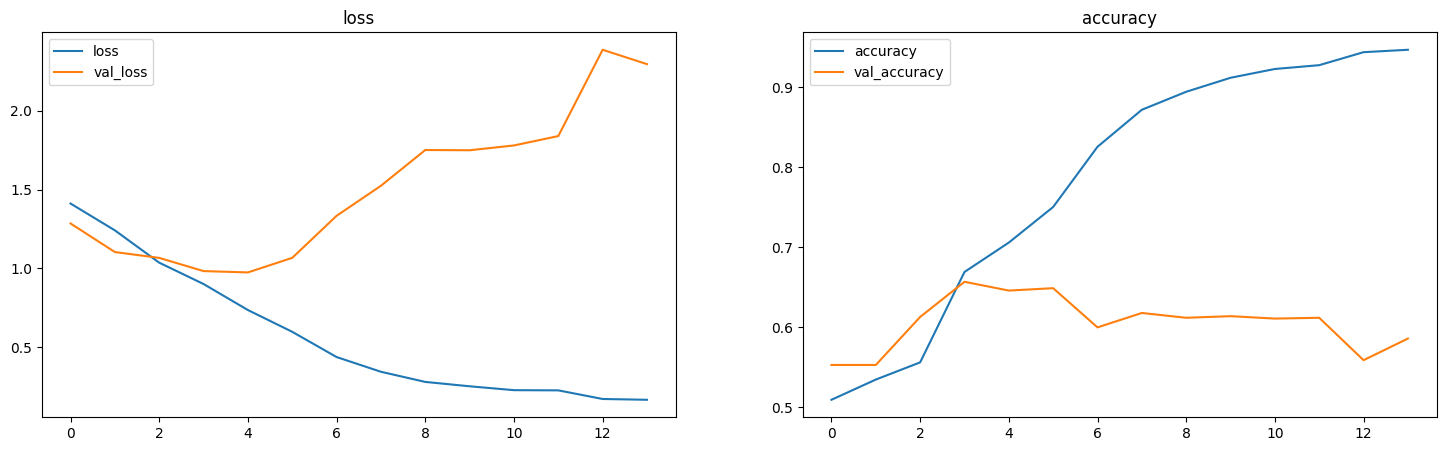

In [ ]:
# Plot the learning curves and analyze them
babysit(history.history)

<font color="red">[ TO DO STUDENTS]</font>

Does the network learn better? Does the network perform well? Study the learning curves and justify your statements with the study of its performance (classification report and confusion matrix)


**The model is exhibiting positive signs of learning during training as evidenced by the improving training loss and accuracy across epochs. Additionally, initial improvements in validation loss and accuracy indicate effective generalization. Nonetheless, there is a subsequent decline in validation accuracy after a certain number of epochs, signaling a potential challenge in maintaining generalization performance.**


On my code, it seems that the ReLU activation for sparsity has helped to solve the problem, but the model still struggles to learn and to get good performance on the validation set.

### c) Experiment on residual connections

<font color="red">[ TO DO STUDENTS ]<color>
* Create a function to generate models with residual connections.
* Using ReLU activation + residual connections, are you able to get better results ?
* Provide here a description of the learning and performances of your network
* Compare it to previous models. What are your conclusions ?

In [ ]:
def build_residual_model(vectorizer, activation, n_hiddenlayers, hidden_dim):

    inputs = layers.Input(shape=(feature_vector_length,), dtype=tf.string)

    x = vectorizer(inputs)

    x = layers.Dense(hidden_dim, activation=activation)(x)
    x = layers.Dense(hidden_dim, activation=activation)(x)
    for _ in range(n_hiddenlayers // 2 - 1):
        last_input = x
        x = layers.Dense(hidden_dim, activation=activation)(x)
        x = layers.Dense(hidden_dim, activation=activation)(x)
        x = x + last_input

    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
# Build a network with 30 hidden layers with 'relu' activations
model = build_residual_model(vectorize_layer, 'relu', 30, hidden_dim)

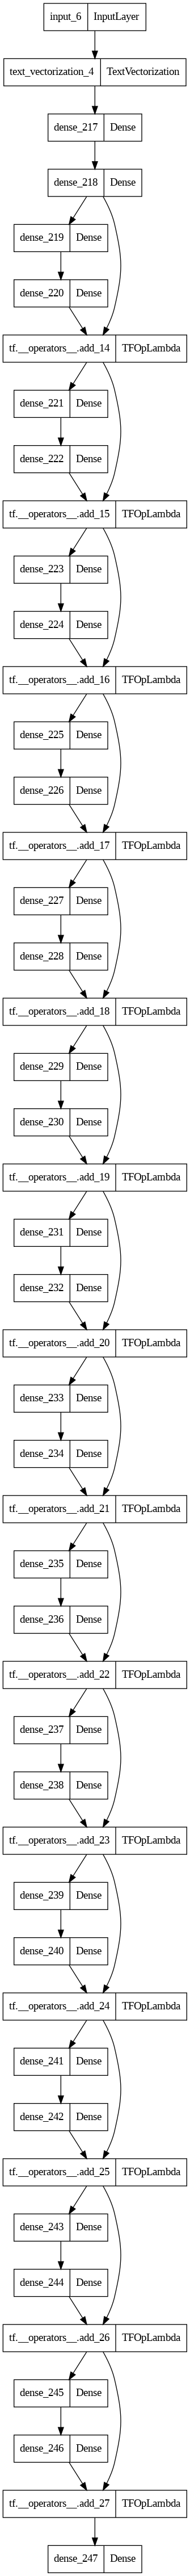

In [ ]:
# Print and plot the model --> What is the best solution ?

plot_model(model)# Plot the model


In [ ]:
# Configure the model and start training
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # For multi-class classification
              metrics=['accuracy'])
history = model.fit(X_train, y_train_encoded,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks_list)

Epoch 1/100
16/16 [==============================] - 11s 205ms/step - loss: 1.6358 - accuracy: 0.4765 - val_loss: 1.1875 - val_accuracy: 0.5530
Epoch 2/100
16/16 [==============================] - 4s 237ms/step - loss: 1.0161 - accuracy: 0.6010 - val_loss: 0.9629 - val_accuracy: 0.6410
Epoch 3/100
16/16 [==============================] - 3s 207ms/step - loss: 0.7174 - accuracy: 0.7225 - val_loss: 1.0362 - val_accuracy: 0.6620
Epoch 4/100
16/16 [==============================] - 3s 163ms/step - loss: 0.5162 - accuracy: 0.7993 - val_loss: 1.4470 - val_accuracy: 0.5330
Epoch 5/100
16/16 [==============================] - 3s 178ms/step - loss: 0.3604 - accuracy: 0.8670 - val_loss: 1.3776 - val_accuracy: 0.5920
Epoch 6/100
16/16 [==============================] - 3s 162ms/step - loss: 0.2590 - accuracy: 0.9065 - val_loss: 1.6649 - val_accuracy: 0.5960
Epoch 7/100
16/16 [==============================] - 5s 345ms/step - loss: 0.1529 - accuracy: 0.9507 - val_loss: 2.0137 - val_accuracy: 0.593

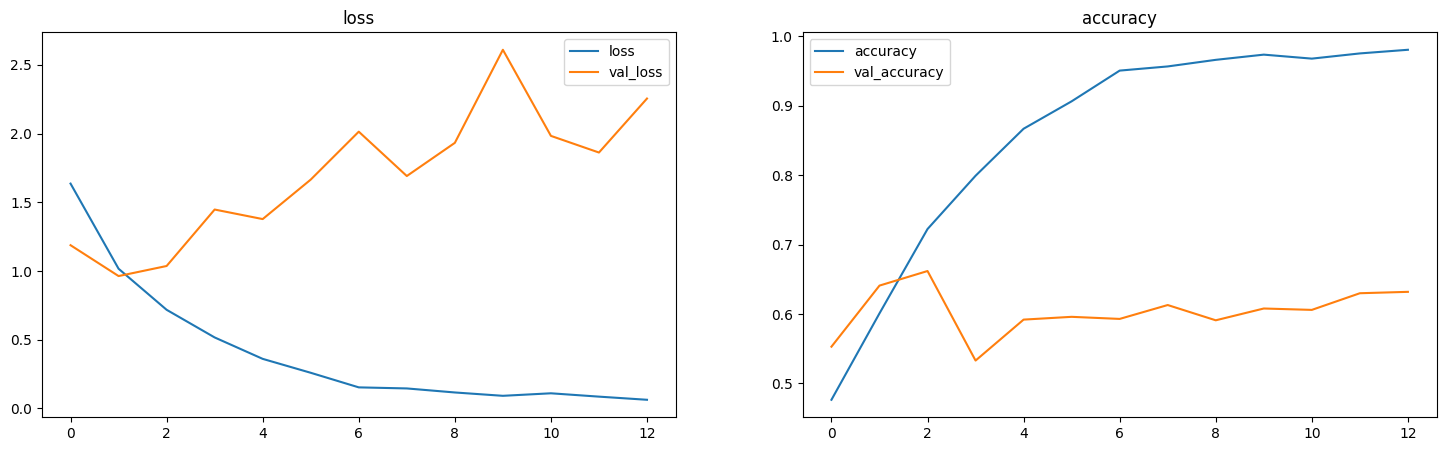

In [ ]:
# Plot the learning curves and analyze them
babysit(history.history)

### d) Experiment on Batch Normalization

<font color="red">[ TO DO STUDENTS ]</font>
* step1: adapt build_model function to add batch normalization layers after the output of the hidden dense layers.
* step2: adapt build_model function to use batch normalization layers and residuals
             
* In both case use ReLU activation and 30 hidden layers as previouly
* Compare your results

In [ ]:
def build_model_batch_normalization(vectorizer, activation, n_hiddenlayers, hidden_dim):
    inputs = layers.Input(shape=(1),dtype="string")
    x = vectorizer(inputs)
    for i in range(n_hiddenlayers):
        x = layers.Dense(hidden_dim,activation=activation)(x)
        x = layers.BatchNormalization()(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def build_residual_model_residual_batch_normalization(vectorizer, activation, n_hiddenlayers, hidden_dim):
    inputs = layers.Input(shape=(feature_vector_length,), dtype=tf.string)

    x = vectorizer(inputs)

    x = layers.Dense(hidden_dim, activation=activation)(x)
    x = layers.Dense(hidden_dim, activation=activation)(x)
    for _ in range(n_hiddenlayers // 2 - 1):
        last_input = x
        x = layers.Dense(hidden_dim, activation=activation)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(hidden_dim, activation=activation)(x)
        x = layers.BatchNormalization()(x)
        x = x + last_input

    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [ ]:
#Build and train the network with BatchNormalization layer
model = build_model_batch_normalization(vectorize_layer, 'relu', 30, hidden_dim)
model.summary()
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train_encoded, batch_size=batch_size,callbacks=[callbacks_list[0]], epochs=epochs, validation_split=0.2)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 11001)             0         
 Vectorization)                                                  
                                                                 
 dense_248 (Dense)           (None, 256)               2816512   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_249 (Dense)           (None, 256)               65792     
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024

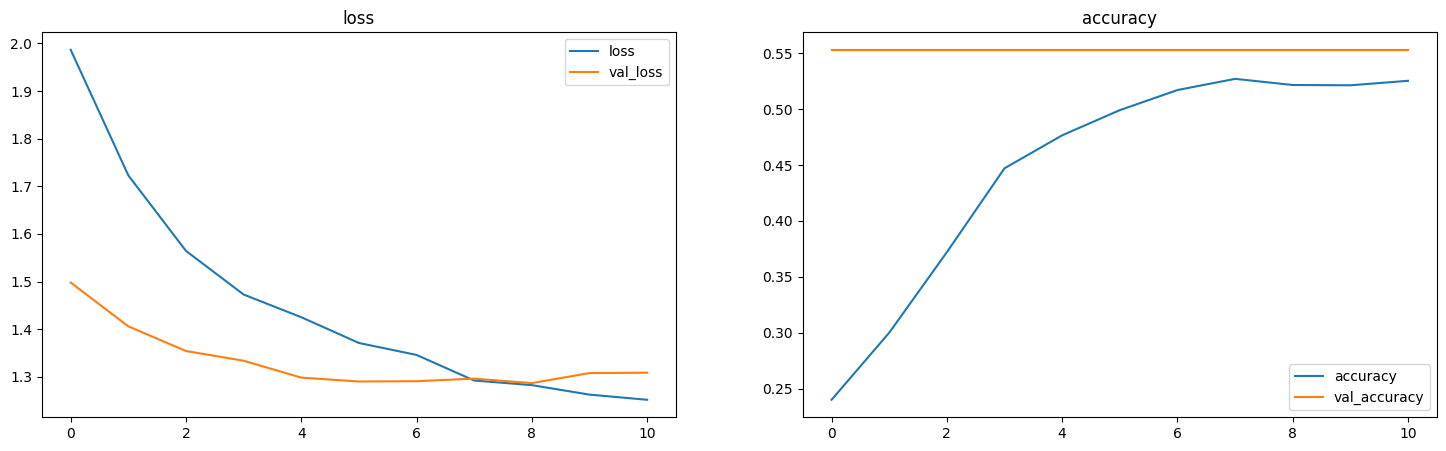

In [ ]:
babysit(history.history)

In [ ]:
# Do the same with `build_residual_model_residual_batch_normalization`
model = build_residual_model_residual_batch_normalization(vectorize_layer, 'relu', 30, hidden_dim)
model.summary()
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train_encoded, batch_size=batch_size,callbacks=[callbacks_list[0]], epochs=epochs, validation_split=0.2)

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_4 (Text  (None, 11001)                0         ['input_8[0][0]']             
 Vectorization)                                                                                   
                                                                                                  
 dense_279 (Dense)           (None, 256)                  2816512   ['text_vectorization_4[7][0]']
                                                                                                  
 dense_280 (Dense)           (None, 256)                  65792     ['dense_279[0][0]']     

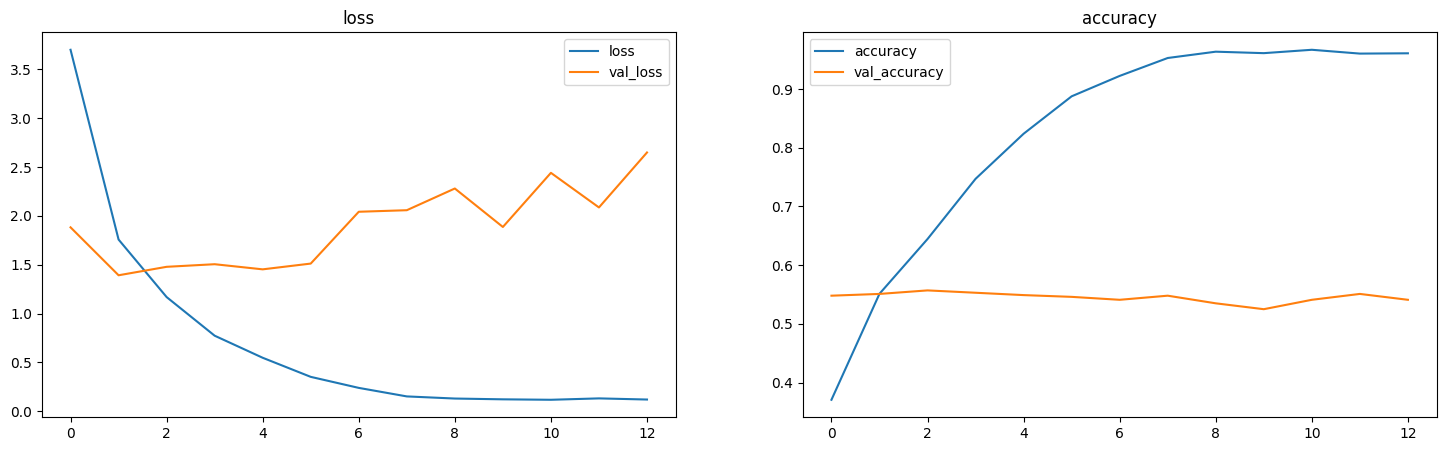

In [ ]:
babysit(history.history)

### e) What if you simply reduce the network depth ?

<font color="red">[ TO DO STUDENTS ]</font>
* build a MLP with ReLU activation composed of 10 hidden layers
* compare your results both in terms of learning and performances compared to other models

In [ ]:
#Build and train the network without residual connections
model = build_model(vectorize_layer, 'relu', 10, hidden_dim)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train_encoded, batch_size=batch_size,callbacks=[callbacks_list[0]], epochs=epochs, validation_split=0.2)


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_4 (Text  (None, 11001)             0         
 Vectorization)                                                  
                                                                 
 dense_310 (Dense)           (None, 256)               2816512   
                                                                 
 dense_311 (Dense)           (None, 256)               65792     
                                                                 
 dense_312 (Dense)           (None, 256)               65792     
                                                                 
 dense_313 (Dense)           (None, 256)               65792     
                                                           

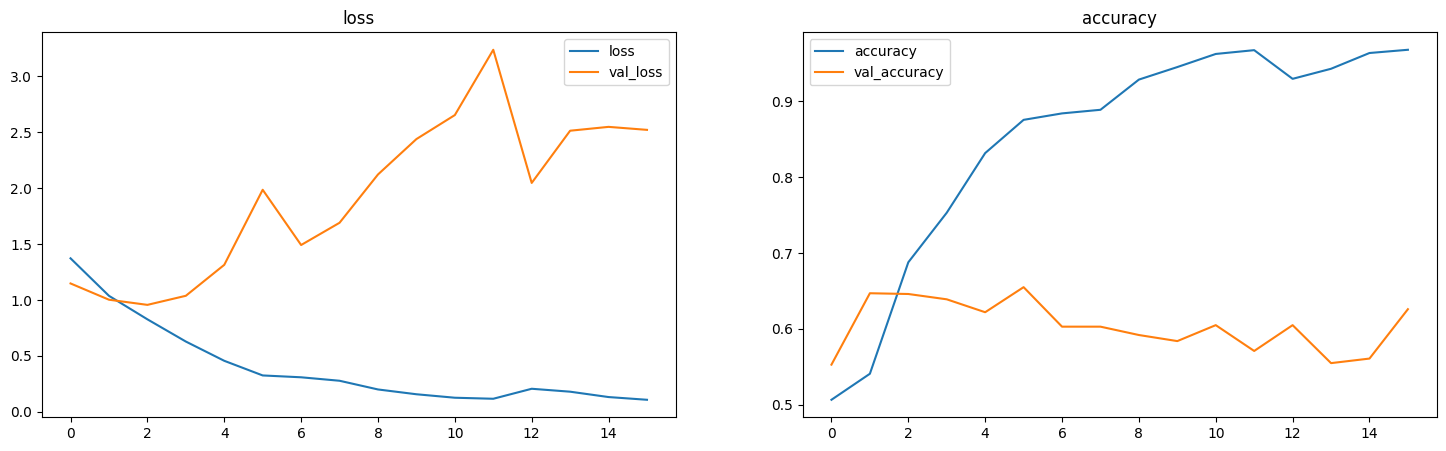

In [ ]:
# Plot the learning curves and analyze them
babysit(history.history)

Normally, you observed a typical instance of overfitting.

## Step 2.  Underfitting and Overfitting problems

Actually what you observed in the last experiment is a typical instance of overfitting.

### a) Decrease the network size ?

In [ ]:
#Build and train the network without residual connections
model = build_model(vectorize_layer, 'relu', 5, hidden_dim)

In [ ]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train_encoded, batch_size=batch_size,callbacks=[callbacks_list[0]], epochs=epochs, validation_split=0.2)

Epoch 1/100
16/16 [==============================] - 4s 175ms/step - loss: 1.3434 - accuracy: 0.5305 - val_loss: 1.1189 - val_accuracy: 0.5650
Epoch 2/100
16/16 [==============================] - 2s 100ms/step - loss: 0.9319 - accuracy: 0.6535 - val_loss: 0.9358 - val_accuracy: 0.6470
Epoch 3/100
16/16 [==============================] - 2s 102ms/step - loss: 0.6263 - accuracy: 0.7480 - val_loss: 1.0089 - val_accuracy: 0.6520
Epoch 4/100
16/16 [==============================] - 2s 118ms/step - loss: 0.4009 - accuracy: 0.8575 - val_loss: 1.5152 - val_accuracy: 0.6280
Epoch 5/100
16/16 [==============================] - 5s 293ms/step - loss: 0.2712 - accuracy: 0.9085 - val_loss: 1.8532 - val_accuracy: 0.5300
Epoch 6/100
16/16 [==============================] - 3s 175ms/step - loss: 0.1906 - accuracy: 0.9385 - val_loss: 1.9460 - val_accuracy: 0.6020
Epoch 7/100
16/16 [==============================] - 2s 97ms/step - loss: 0.1692 - accuracy: 0.9565 - val_loss: 2.3055 - val_accuracy: 0.6510


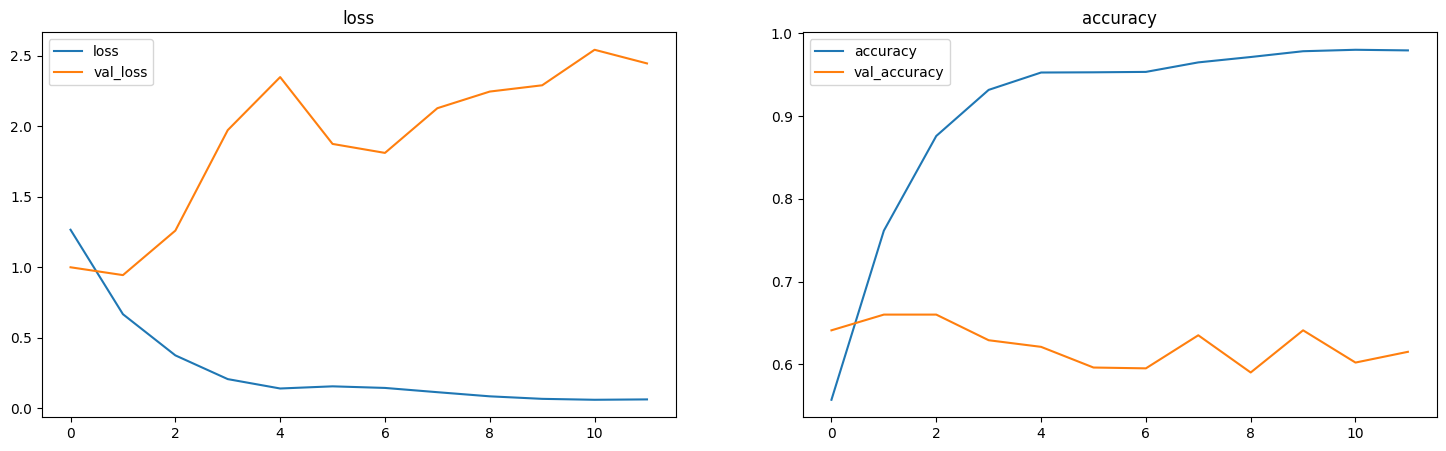

In [ ]:
babysit(history.history)

For me: it gets slightly better but almost the same behavior is observed when taking 10 and 5 hidden layers.

What's going on for you ?
almost the same results when taking 10 hidden layers

### b) Experiment on L2 regularization

<font color="red">[ TO DO STUDENTS ]</font>
* check the keras documentation on regularizations https://keras.io/api/layers/regularizers/
* Add to the previous network L2 regularization: first with l2_reg = 0.01 / then with l2_reg= 0.0001
* Compare results

In [ ]:
# Design the model function
from tensorflow.keras import regularizers

def build_model_reg(vectorizer, activation, n_hiddenlayers, hidden_dim, l2_reg = 0.01):
    inputs = layers.Input(shape=(1),dtype="string")
    x = vectorizer(inputs)
    for i in range(n_hiddenlayers):
        x = layers.Dense(hidden_dim,activation=activation, kernel_regularizer=regularizers.l2(l2_reg))(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model
#the model is forced to use smaller weights, preventing overfitting. However, if the regularization strength is too high, it may also hinder the model's ability to learn complex patterns in the data.
#When λ=0.0001,he regularization strength is lower. In this case, the penalty for large weights is milder compared to the scenario with λ=0.01
#The model is still regularized, but it has more freedom to use larger weights during training.

In [ ]:
#Build and train the network without residual connections
model = build_model_reg(vectorize_layer, 'relu', 5, hidden_dim, 0.01)

In [ ]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train_encoded, batch_size=batch_size,callbacks=[callbacks_list[0]], epochs=epochs, validation_split=0.2)

Epoch 1/100
16/16 [==============================] - 3s 126ms/step - loss: 1.1339 - accuracy: 0.6898 - val_loss: 1.2392 - val_accuracy: 0.6350
Epoch 2/100
16/16 [==============================] - 2s 106ms/step - loss: 1.0037 - accuracy: 0.7057 - val_loss: 1.2107 - val_accuracy: 0.6400
Epoch 3/100
16/16 [==============================] - 2s 106ms/step - loss: 0.9290 - accuracy: 0.7305 - val_loss: 1.2397 - val_accuracy: 0.6460
Epoch 4/100
16/16 [==============================] - 2s 151ms/step - loss: 0.8936 - accuracy: 0.7678 - val_loss: 1.3006 - val_accuracy: 0.6390
Epoch 5/100
16/16 [==============================] - 3s 170ms/step - loss: 0.8963 - accuracy: 0.7648 - val_loss: 1.3114 - val_accuracy: 0.6290
Epoch 6/100
16/16 [==============================] - 2s 103ms/step - loss: 0.8720 - accuracy: 0.7918 - val_loss: 1.3527 - val_accuracy: 0.6310
Epoch 7/100
16/16 [==============================] - 2s 102ms/step - loss: 0.8434 - accuracy: 0.8070 - val_loss: 1.4155 - val_accuracy: 0.6180

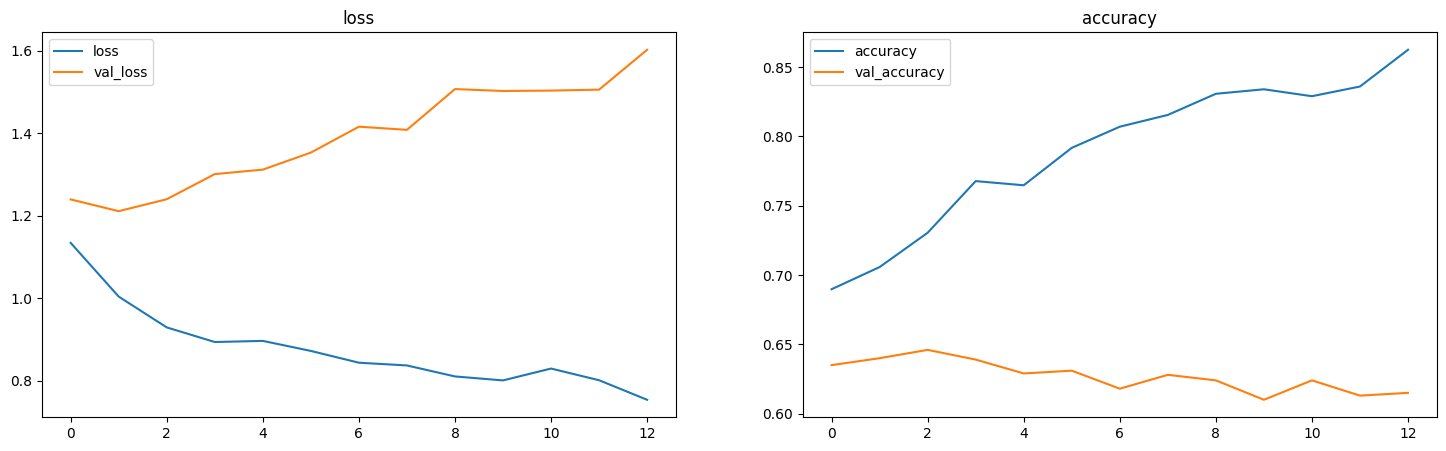

In [ ]:
# Plot the learning curves and analyze them
babysit(history.history)

<font color="red">[ TO DO STUDENTS]</font code="red">

Reduce the coefficient of L2 regularization taken into account in the loss from l2_reg = 0.01 > to l2_reg = 0.0001 and do the same experimentation.

Epoch 1/100
16/16 [==============================] - 4s 169ms/step - loss: 1.5205 - accuracy: 0.5117 - val_loss: 1.2364 - val_accuracy: 0.5560
Epoch 2/100
16/16 [==============================] - 3s 192ms/step - loss: 1.0555 - accuracy: 0.6360 - val_loss: 1.0239 - val_accuracy: 0.6620
Epoch 3/100
16/16 [==============================] - 2s 135ms/step - loss: 0.7500 - accuracy: 0.7250 - val_loss: 1.0322 - val_accuracy: 0.6620
Epoch 4/100
16/16 [==============================] - 2s 121ms/step - loss: 0.5604 - accuracy: 0.8163 - val_loss: 1.3574 - val_accuracy: 0.6120
Epoch 5/100
16/16 [==============================] - 2s 119ms/step - loss: 0.4133 - accuracy: 0.8900 - val_loss: 1.8554 - val_accuracy: 0.6430
Epoch 6/100
16/16 [==============================] - 2s 120ms/step - loss: 0.3546 - accuracy: 0.9105 - val_loss: 1.7047 - val_accuracy: 0.6550
Epoch 7/100
16/16 [==============================] - 2s 120ms/step - loss: 0.2791 - accuracy: 0.9423 - val_loss: 1.8801 - val_accuracy: 0.6130

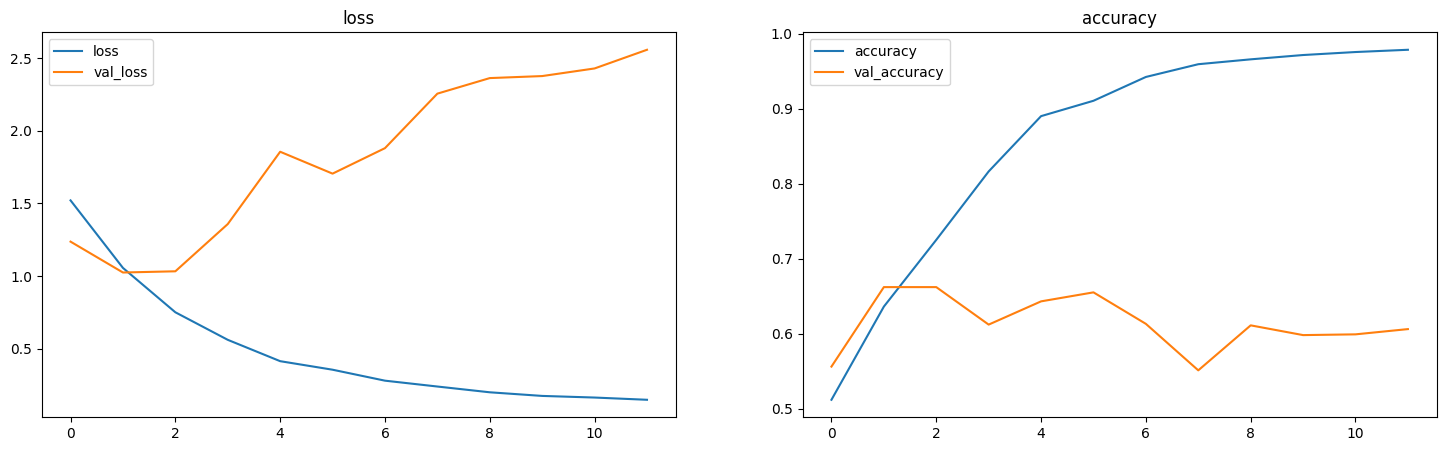

In [ ]:
model = build_model_reg(vectorize_layer, 'relu', 5, hidden_dim, 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train_encoded, batch_size=batch_size,callbacks=[callbacks_list[0]], epochs=epochs, validation_split=0.2)
babysit(history.history)

What is your conclusion ?
**regularization didn't prevent from overfitting**


### c) Experiment on Dropout

<font color="red">[TO DO STUDENTS]</font>
* Observe the provided results for a dropout ratio of p=0.7 and p=0.3
* What are your conclusions ?
* In the end, considering all the explored settings in this Lab, what would you suggest as a network to get a better model ?

In [ ]:
#When dropout is applied to the input layer with a dropout ratio
#p, it means that during each training iteration, a fraction
#p of the input units are randomly set to zero.
#This dropout process helps prevent overfitting
#by introducing noise and encouraging the network to be more robust,
#as it cannot rely too heavily on any specific input feature.

# Design the model function
from keras.layers import Dropout

def build_model_dropout(vectorizer, activation, n_hiddenlayers, hidden_dim, p = 0.5):
    inputs = layers.Input(shape=(1), dtype="string")
    x = vectorizer(inputs)

    for i in range(n_hiddenlayers):
        x = layers.Dense(hidden_dim, activation=activation)(x)
        x = Dropout(p)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Build and train the network without residual connections
model = build_model_dropout(vectorize_layer, 'relu', 5, hidden_dim, 0.7)

In [ ]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train_encoded, batch_size=batch_size,callbacks=[callbacks_list[0]], epochs=epochs, validation_split=0.2)


Epoch 1/100
16/16 [==============================] - 4s 143ms/step - loss: 1.6039 - accuracy: 0.4175 - val_loss: 1.4870 - val_accuracy: 0.5530
Epoch 2/100
16/16 [==============================] - 2s 127ms/step - loss: 1.4499 - accuracy: 0.5222 - val_loss: 1.3745 - val_accuracy: 0.5530
Epoch 3/100
16/16 [==============================] - 4s 235ms/step - loss: 1.3420 - accuracy: 0.5330 - val_loss: 1.2811 - val_accuracy: 0.5530
Epoch 4/100
16/16 [==============================] - 2s 123ms/step - loss: 1.3007 - accuracy: 0.5325 - val_loss: 1.2617 - val_accuracy: 0.5530
Epoch 5/100
16/16 [==============================] - 2s 121ms/step - loss: 1.2308 - accuracy: 0.5340 - val_loss: 1.2078 - val_accuracy: 0.5530
Epoch 6/100
16/16 [==============================] - 2s 127ms/step - loss: 1.1805 - accuracy: 0.5340 - val_loss: 1.1853 - val_accuracy: 0.5530
Epoch 7/100
16/16 [==============================] - 2s 117ms/step - loss: 1.1206 - accuracy: 0.5345 - val_loss: 1.1151 - val_accuracy: 0.5530

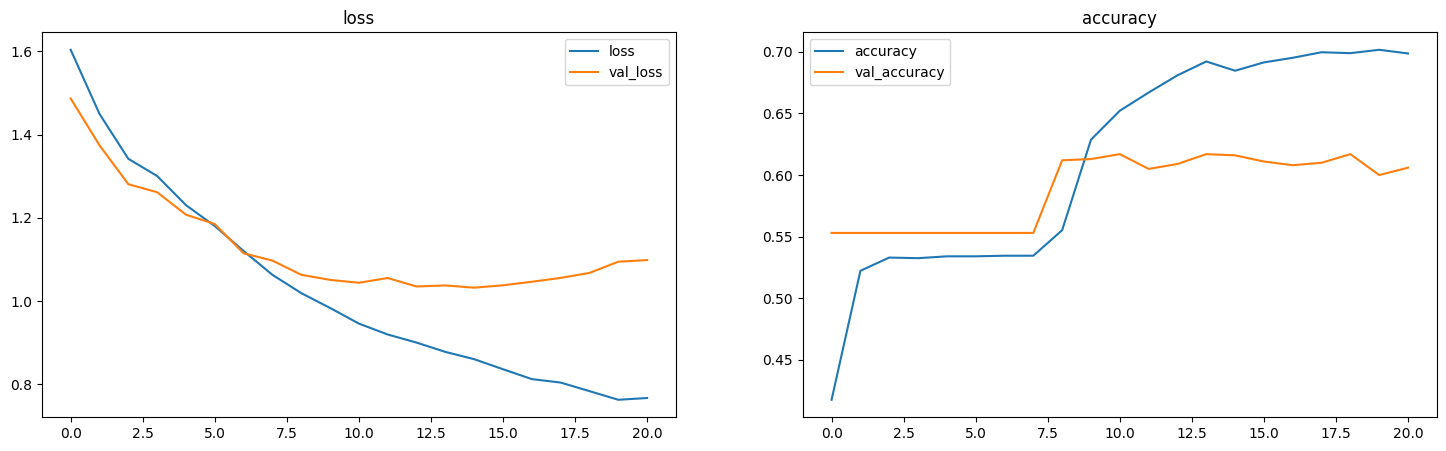

In [ ]:
# Plot the learning curves and analyze them
babysit(history.history)

<font color="red">[ TO DO STUDENTS]</font code="red">

Decrease the proportion of neurons deactivated at each forward pass, from 0.7 to 0.3

In [ ]:
model = build_model_dropout(vectorize_layer, 'relu', 5, hidden_dim, 0.3)

In [ ]:
# Configure the model and start training
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train,y_train_encoded, batch_size=batch_size,callbacks=[callbacks_list[0]], epochs=epochs, validation_split=0.2)


Epoch 1/100
16/16 [==============================] - 4s 142ms/step - loss: 1.4330 - accuracy: 0.5160 - val_loss: 1.1825 - val_accuracy: 0.5530
Epoch 2/100
16/16 [==============================] - 3s 187ms/step - loss: 1.1285 - accuracy: 0.5357 - val_loss: 1.0694 - val_accuracy: 0.5630
Epoch 3/100
16/16 [==============================] - 3s 162ms/step - loss: 0.9538 - accuracy: 0.6208 - val_loss: 0.9706 - val_accuracy: 0.6490
Epoch 4/100
16/16 [==============================] - 2s 121ms/step - loss: 0.7803 - accuracy: 0.7010 - val_loss: 0.9596 - val_accuracy: 0.6540
Epoch 5/100
16/16 [==============================] - 2s 116ms/step - loss: 0.6301 - accuracy: 0.7435 - val_loss: 1.0059 - val_accuracy: 0.6300
Epoch 6/100
16/16 [==============================] - 2s 116ms/step - loss: 0.5167 - accuracy: 0.7968 - val_loss: 1.1603 - val_accuracy: 0.6290
Epoch 7/100
16/16 [==============================] - 2s 115ms/step - loss: 0.4295 - accuracy: 0.8378 - val_loss: 1.2706 - val_accuracy: 0.6160

What is your conclusion ?
**None of these technics prevented our model from overfitting**


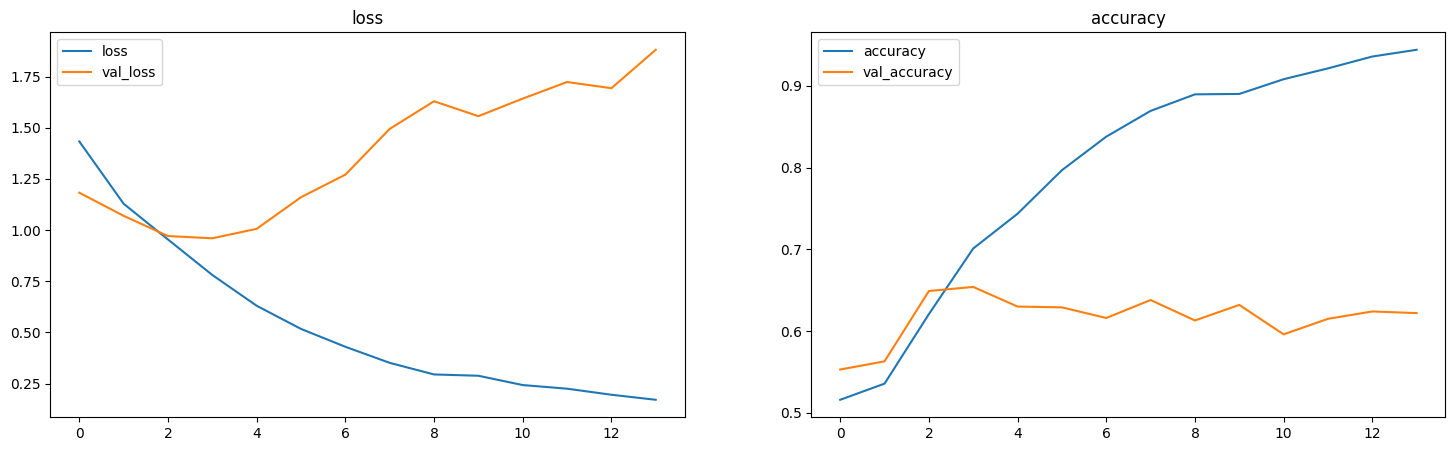

In [ ]:
# Plot the learning curves and analyze them
babysit(history.history)

## Step 3. Stop and resume training (Mandatory for MSc. DSAI Students)

Learning how to start, stop and resume learning a deep learning model is a very important skill to master. At some point:

* You have limited time on a GPU instance (this can happen on Google Colab or when using the cheaper Amazon EC2 point instances).
* Your SSH connection is broken.
* Your deep learning platform crashes and shuts down.

Imagine you've spent a whole week training a state-of-the-art deep neural network... and your model is lost due to a power failure! Fortunately, there is a solution - but when these situations occur, you need to know what to do:

1. Take a snapshot model that was saved/serialized to disk during training.
1. Load the model into memory.
1. Resume training where you left off.

Starting, stopping and resuming training is standard practice when setting the learning rate manually:

1. Start training your model until the loss/accuracy reaches a plateau.
1. Take a snapshot of your model every N epochs (typically N={1, 5, 10})
1. Stop training when you arrive at a plateau (by forcing out via ctrl + c or via earlystopping
1. Adjust your learning rate (typically by reducing it by an order of magnitude).
1. Restart the training script, starting from the last snapshot of the model weights

The ability to adjust the learning rate is an essential skill for any deep learning practitioner to master, so take the time to study and practice it!

<font color="red">Look at the documentation Tensorflow has proposed for ModelCheckpoint: we want to save the model at the end of each epoch so that we can restore it later.</font>

In [ ]:
# Reuse one the previous model and reset it
# Use sgd as optimizer and fix learning_rate = 0.1
# Use 2 callbacks : EarlyStopping and ModelCheckpoint
# Save model at each epoch
# Fit the network
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
model_path = "./model.checkpoint"

X_train, X_val, y_train_encoded, y_val_encoded = train_test_split(X_train, y_train_encoded, test_size=0.2)

model = build_model_dropout(vectorize_layer, 'relu', 5, hidden_dim, 0.5)

opt = optimizers.SGD(learning_rate=0.1) # Fix learning rate to 0.1
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

callbacks_list = [EarlyStopping(monitor='val_accuracy', mode='max',
                                patience=patience,
                                restore_best_weights=True),
                  ModelCheckpoint(filepath=model_path,
                                  save_weights_only=False,
                                  save_best_only=True,
                                  monitor='val_loss',
                                  mode='min',
                                 )]
history1 = model.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded),
                    epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=0)

In [ ]:
# Re-load the model
new_model = tf.keras.models.load_model(model_path, compile=True)

load_weights:

This function is used to load only the weights of a model from a saved file. The weights are typically saved separately from the model architecture and optimizer settings. This is useful when you have a model with the same architecture, and you want to transfer or initialize the learned weights.

load_model:

This function is used to load an entire model, including its architecture, optimizer settings, and learned weights, from a saved file.  The saved model file contains all the information needed to reconstruct the model, and you can continue training it or use it for inference.

In [ ]:
# Change learning_rate = 0.01
new_model.optimizer.lr.assign(0.01)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.01>

In [ ]:
# Continue to fit the network
history2 = new_model.fit(X_train, y_train_encoded, validation_data=(X_val, y_val_encoded),
                    epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=0)

## Step 4. Use Keras-tuner Mandatory for MSc. DSAI Students)

<font color="red">[TO DO STUDENTS]</font>

From the previous experiences use Keras-tuner to find the best possible network.

Keras-Tuner must build at least 3 different network architectures:
* Dense cells only
* Addition of residuals
* Adding batch normalisation
* Adding dropout
* A combination of the different additions


In [ ]:
""" your code here """